## AUCell

In [1]:
# load packages
import sys
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import os, glob, re, pickle
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.prune import prune2df, df2regulons, _distributed_calc
from pyscenic.cli.utils import load_signatures

from IPython.display import HTML, display

In [3]:
#check if correct kernel is loaded (scenic_protocol)
sys.executable

'/home/yilin/anaconda3/envs/scenic_protocol/bin/python'

In [4]:
adata = sc.read_h5ad("/home/yilin/PCA/epi.h5ad")

In [5]:
# load aggregated regulons
regulons = load_signatures('agg.regulons.dat')

In [6]:
len(regulons)

193

In [7]:
adata

AnnData object with n_obs × n_vars = 22985 × 33391
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'leiden', 'label'
    var: 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'batch_colors', 'label_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
%%time
# run aucell function
auc_mtx = aucell(adata.to_df(), regulons, num_workers=24)
auc_mtx.to_csv('result.auc.csv')

CPU times: user 22.6 s, sys: 6.84 s, total: 29.4 s
Wall time: 50.7 s


In [10]:
auc = sc.read_csv('result.auc.csv')

In [11]:
auc.write_h5ad('auc_epi.h5ad',compression='gzip')

In [12]:
auc = sc.read_h5ad('auc_epi.h5ad')

In [13]:
sc.pp.scale(auc)
sc.pp.pca(auc,random_state=0)
neighborhood_k = np.sqrt(auc.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(auc,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances
sc.tl.umap(auc,min_dist=0.15,random_state=0)
sc.tl.leiden(auc,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

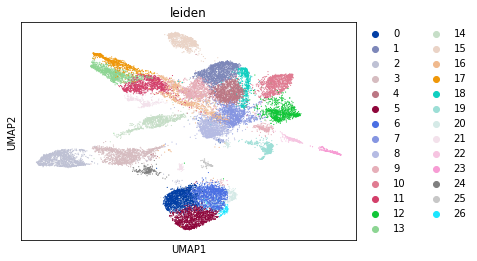

In [14]:
sc.pp.normalize_total(adata) #Normalize data by the median counts per single cell library
adata.X = np.arcsinh(adata.X).copy() #Transform the data by using an inverse hyperbolic sine transform, this eliminates the need for adding a pseudocount 
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances
sc.tl.umap(adata,min_dist=0.15,random_state=0)
sc.tl.leiden(adata,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.
sc.pl.umap(adata,color=['leiden'],use_raw=False,cmap='viridis')

In [15]:
# save the umap coordinates for auc and adata
pd.DataFrame(auc.obsm['X_umap']).to_csv("X_umap_aucell.csv",index=None,header=None)
pd.DataFrame(adata.obsm['X_umap']).to_csv("X_umap_adata.csv",index=None,header=None)

In [17]:
adata_new = adata.copy()
adata_new.obsm['X_umap'] = auc.obsm['X_umap']
adata_new.obs['leiden'] = auc.obs['leiden']

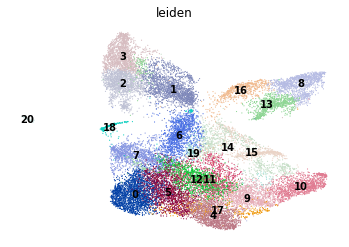

In [18]:
sc.pl.umap(adata_new,color=['leiden'],use_raw=False,cmap='viridis',legend_loc='on data',frameon=False)

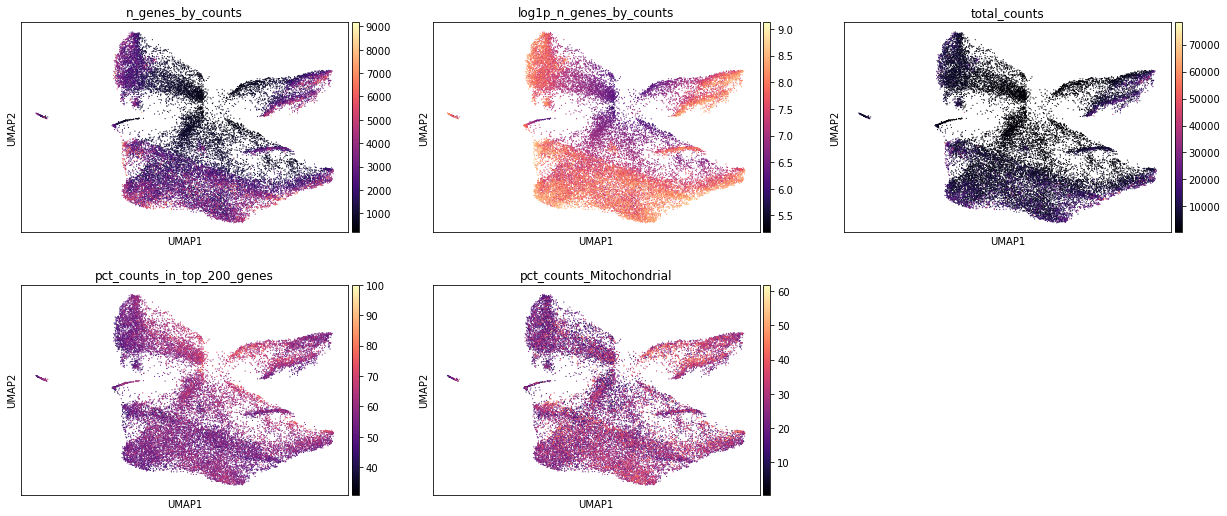

In [21]:
sc.pl.umap(adata_new,color=['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts','pct_counts_in_top_200_genes','pct_counts_Mitochondrial'],legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='magma',ncols=3,use_raw=False)

In [36]:
adata_new

AnnData object with n_obs × n_vars = 22985 × 33391
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'leiden', 'label'
    var: 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'batch_colors', 'label_colors', 'leiden', 'neighbors', 'pca', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [28]:
adata_new_filter = adata_new[adata_new.obs['log1p_n_genes_by_counts']>=6.5]

In [29]:
adata_new_filter

View of AnnData object with n_obs × n_vars = 21480 × 33391
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'leiden', 'label'
    var: 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'batch_colors', 'label_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

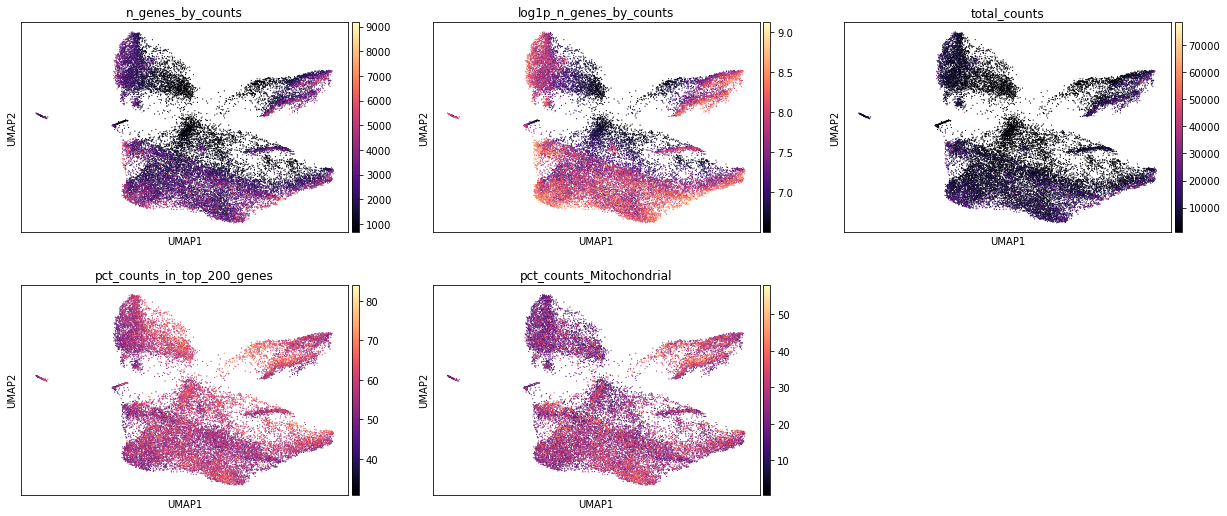

In [30]:
sc.pl.umap(adata_new_filter,color=['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts','pct_counts_in_top_200_genes','pct_counts_Mitochondrial'],legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='magma',ncols=3,use_raw=False)

In [31]:
marker_genes_dict_normal={
    'CT':['OTOP2','MEIS1'],
    'ABS':['KRT20','GUCA2A','ALDOB'],
    'SSC':['MSLN','MUC5AC','AQP5','TACSTD2','FSCN1','TFF2','ANXA1','ANXA10','REG4','MUC17','S100P','GSDMB','GSDMD','IL18','RELB','MDK','RARA','RXRA','AHR','AGRN','PDX1'],
    'ASC':['CLDN2','CD44','AXIN2','RNF43','TGFBI','EPHB2','TEAD2','CDX2'],
    'STM':['LGR5','OLFM4','ASCL2'],
    'TAC':['PCNA','MKI67'],
    'GOB':['ATOH1','MUC2','TFF3'],
    'EE':['CHGA','NEUROD1'],
    'TUF':['POU2F3','SOX9'],
}

nonepi_markers={
    'T':['CD8A','CD3D','CD4','TRBC2','CD96','CD247'],
    'MYE':['CSF1R','CSF3R','CD14','MRC1'],
    'MAS':['KIT','KRT1'],
    'CD19':['CD19','CD79A','CD74','HLA-DRA','CD37','CD22','MS4A1'],
    'IGH':['IGHA1','IGHA2','JCHAIN'],
    'END':['VWF','MCAM'],
    'FIB':['COL1A1','FN1'],
}


In [32]:
j = [y for x in [marker_genes_dict_normal.values()] for y in x]
flat_list_1 = [item for sublist in j for item in sublist]
flat_list_1 = [element for element in flat_list_1 if element in adata.var_names]

In [33]:
j = [y for x in [nonepi_markers.values()] for y in x]
flat_list_2 = [item for sublist in j for item in sublist]
flat_list_2 = [element for element in flat_list_2 if element in adata.var_names]

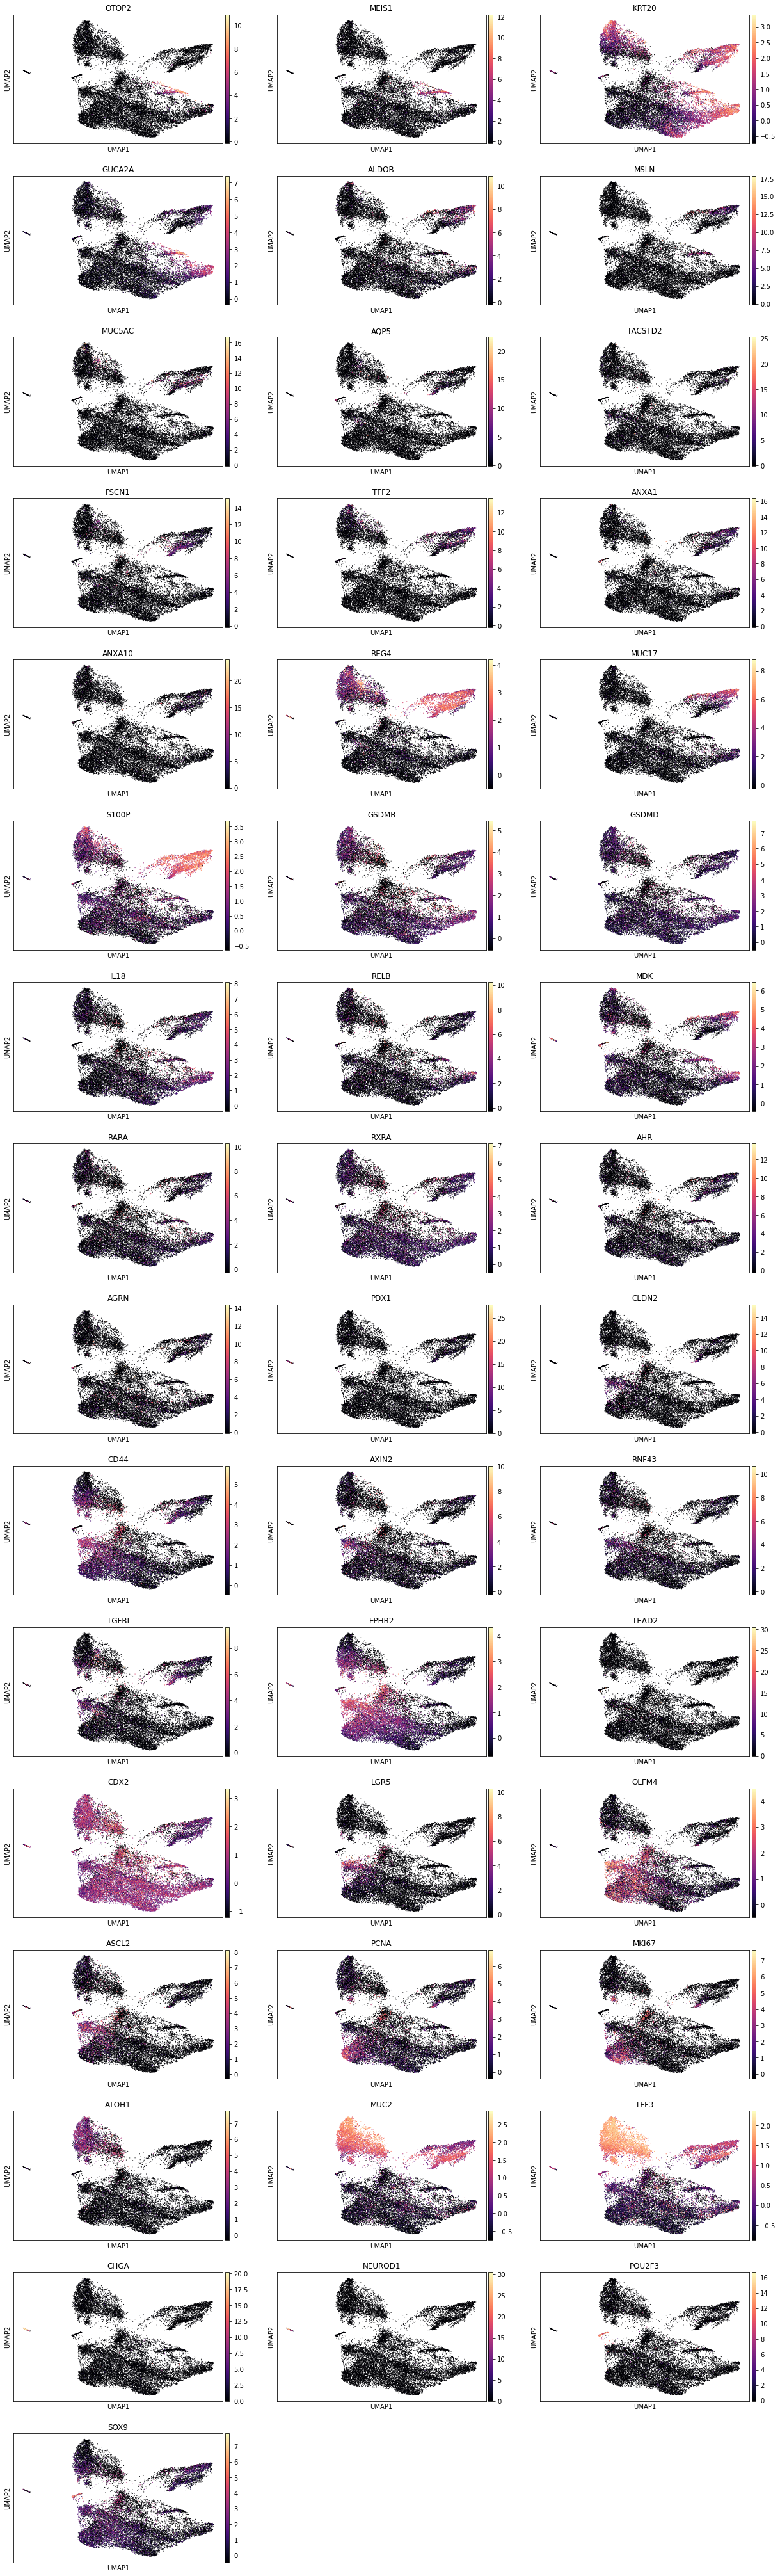

In [34]:
sc.pl.umap(adata_new_filter,color=flat_list_1,legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='magma',ncols=3,use_raw=False)

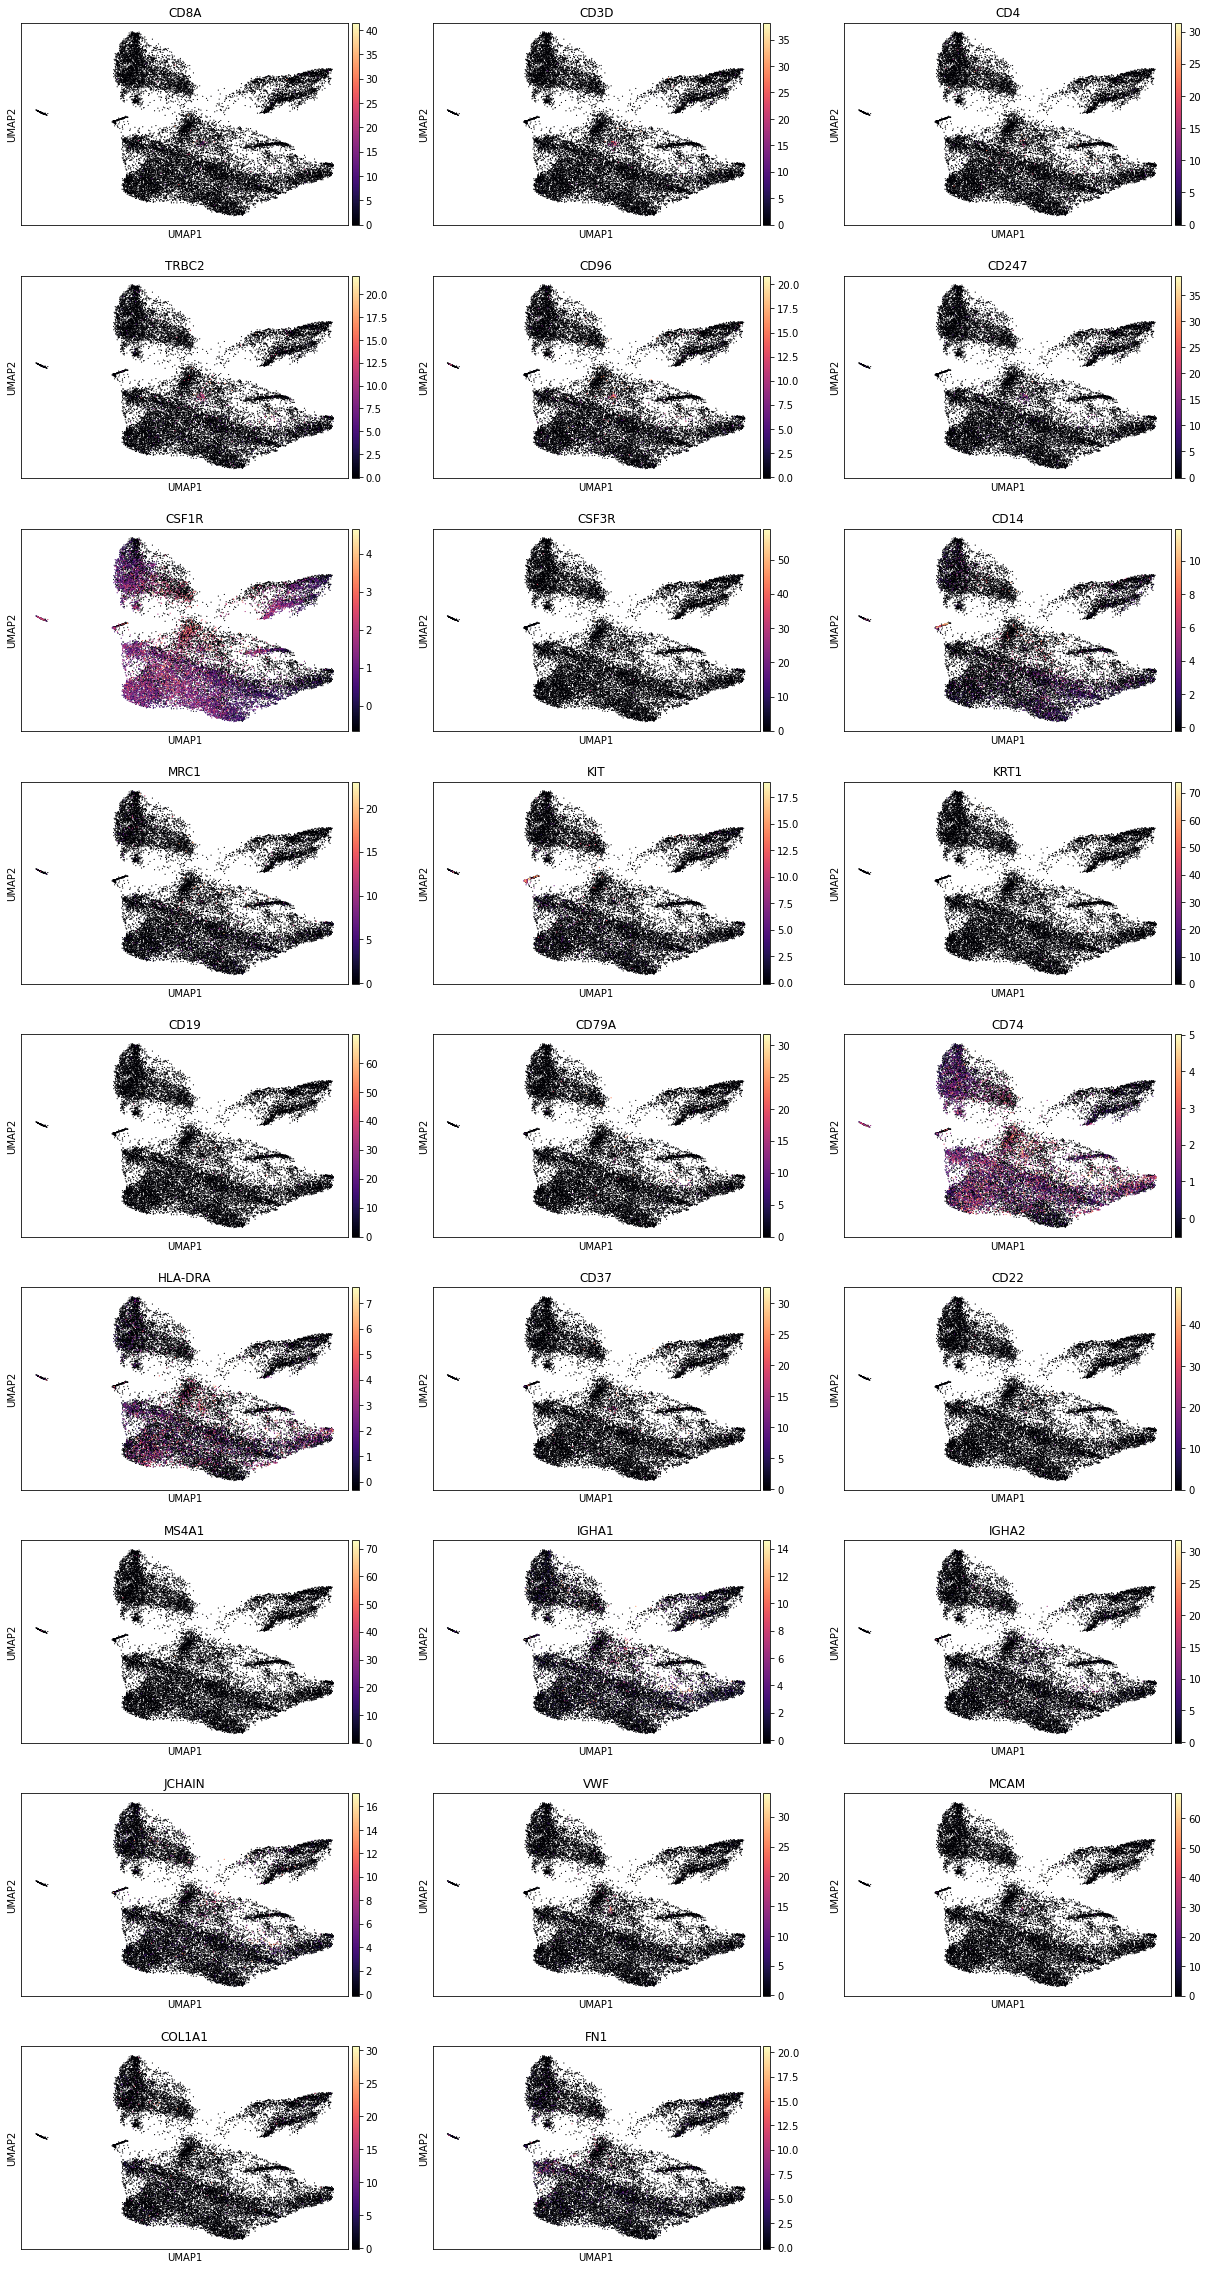

In [35]:
sc.pl.umap(adata_new_filter,color=flat_list_2,legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='magma',ncols=3,use_raw=False)